# ⚽ Wage-Performance Relationship in English Football (2013–2025)
**Leagues:** Premier League & Championship (2013–2025)  
**Purpose:** Analyse the relationship between team wage bills and on-pitch performance using log-linear and non-linear regression models  
**Author:** [Victoria Friss de Kereki](https://www.linkedin.com/in/victoria-friss-de-kereki/)  
**Medium Article:** [Do Wages Really Explain Football Success?](https://medium.com/@vickyfrissdekereki/do-wages-really-explain-football-success-61aba9b0b37d)


**Notebook first written:** `12/01/2026`  
**Last updated:** `28/01/2026`  

> This notebook studies how team wage expenditure relates to league performance in English football. Using log-linear and log–quadratic regression models, it quantifies diminishing returns to spending while avoiding mechanical league effects introduced by constructed performance measures. The analysis focuses on interpretability and robustness rather than maximising goodness-of-fit.

<div style="text-align: left;">
    <img src="Images and others/Do Wages Really Explain Football Success.png" alt="Do Wages Really Explain Football Success" width="600">
</di>
>

## 1. Import packages

In [46]:
# Standard scientific stack
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Statistics
from scipy.stats import zscore

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

## 2. Import Team Payroll Data
##### Team payroll data were previously scraped from [Capology](https://www.capology.com/) and consolidated into a single CSV file covering both leagues and all seasons.

In [5]:
payrolls_all_england = pd.read_csv("payrolls_all_england.csv")

payrolls_all_england.tail()

,Club,Abbreviation,Gross_PW_GBP,Gross_PY_GBP,Adj_Gross_GBP,Keeper_GBP,Defense_GBP,Midfield_GBP,Forward_GBP,Season,League
567,Bournemouth,BOU,1207000.0,62764000.0,62764000.0,4160000.0,17160000.0,17264000.0,24180000.0,2025-2026,Premier League
568,Brighton,BHA,1166250.0,60645000.0,60645000.0,3640000.0,24102000.0,9906000.0,22997000.0,2025-2026,Premier League
569,Leeds,LEE,1140500.0,59306000.0,59306000.0,6240000.0,18200000.0,8580000.0,26286000.0,2025-2026,Premier League
570,Burnley,RNL,1061346.0,55190000.0,55190000.0,4004000.0,22490000.0,9100000.0,19596000.0,2025-2026,Premier League
571,Brentford,BTD,1044250.0,54301000.0,54301000.0,4680000.0,14456000.0,12506000.0,22659000.0,2025-2026,Premier League


##### Key variables include:
##### - Adj_Gross_GBP: Adjusted annual gross wage bill
##### - Wage breakdown by position (Goalkeepers, Defence, Midfield, Forwards)
##### - Season and league identifiers

## 3. Championship and Premier League Final Standings (ESPN Scraping)

Match-level data for the Premier League can be obtained using the [soccerdata package](https://soccerdata.readthedocs.io/).
> ⚠️ Limitation:
> soccerdata does not support Championship data and does not provide final league standings directly. Standings must therefore be reconstructed from match results.


##### Since soccerdata does not support the Championship, final league tables are scraped directly from ESPN for both Premier League and Championship.
> Seasons covered: 2013–2014 to 2024–2025  
> The current season is excluded as it is incomplete.

### 3.1 Championship

In [6]:
all_seasons = []

for year in range(2013, 2025):
    url = f"https://www.espn.com/soccer/standings/_/league/ENG.2/season/{year}" # ENG.2 is Championship
    tables = pd.read_html(url)

    teams_raw = tables[0]
    stats = tables[1]

    teams = pd.DataFrame()
    teams["position"] = teams_raw.iloc[:, 0].str.extract(r"^(\d+)").astype(int)
    teams["team"] = (
        teams_raw.iloc[:, 0]
        .str.replace(r"^\d+", "", regex=True)
        .str.replace(r"^[A-Z]{2,3}", "", regex=True)
        .str.strip()
    )

    stats.columns = ["gp", "w", "d", "l", "gf", "ga", "gd", "pts"]
    stats = stats.apply(lambda c: c.astype(str).str.replace("+", "", regex=False).astype(int))

    df = pd.concat([teams, stats], axis=1)
    df["season"] = f"{year}-{year+1}"

    all_seasons.append(df)

championship = pd.concat(all_seasons, ignore_index=True)

In [7]:
championship.tail()

,position,team,gp,w,d,l,gf,ga,gd,pts,season
283,20,Preston North End,46,10,20,16,48,59,-11,50,2024-2025
284,21,Hull City,46,12,13,21,44,54,-10,49,2024-2025
285,22,Luton Town,46,13,10,23,45,69,-24,49,2024-2025
286,23,Plymouth Argyle,46,11,13,22,51,88,-37,46,2024-2025
287,24,Cardiff City,46,9,17,20,48,73,-25,44,2024-2025


### 3.2 Premier League

In [8]:
all_seasons = []

for year in range(2013, 2025):
    url = f"https://www.espn.com/soccer/standings/_/league/ENG.1/season/{year}" # ENG.1 is Premier League
    tables = pd.read_html(url)

    teams_raw = tables[0]
    stats = tables[1]

    teams = pd.DataFrame()
    teams["position"] = teams_raw.iloc[:, 0].str.extract(r"^(\d+)").astype(int)
    teams["team"] = (
        teams_raw.iloc[:, 0]
        .str.replace(r"^\d+", "", regex=True)
        .str.replace(r"^[A-Z]{2,3}", "", regex=True)
        .str.strip()
    )

    stats.columns = ["gp", "w", "d", "l", "gf", "ga", "gd", "pts"]
    stats = stats.apply(lambda c: c.astype(str).str.replace("+", "", regex=False).astype(int))

    df = pd.concat([teams, stats], axis=1)
    df["season"] = f"{year}-{year+1}"

    all_seasons.append(df)

premierleague = pd.concat(all_seasons, ignore_index=True)

In [9]:
premierleague.tail()

,position,team,gp,w,d,l,gf,ga,gd,pts,season
235,16,Wolverhampton Wanderers,38,12,6,20,54,69,-15,42,2024-2025
236,17,Tottenham Hotspur,38,11,5,22,64,65,-1,38,2024-2025
237,18,Leicester City,38,6,7,25,33,80,-47,25,2024-2025
238,19,Ipswich Town,38,4,10,24,36,82,-46,22,2024-2025
239,20,Southampton,38,2,6,30,26,86,-60,12,2024-2025


## 4. Combine Premier League and Championship tablesnated

##### To allow joint analysis across leagues:
##### - League identifiers are added
##### - Points are standardised using points per game
##### - Tables are vertically concatenated

In [10]:
# Add league identifiers
premierleague["league"] = "Premier League"
premierleague["league_level"] = 1

championship["league"] = "Championship"
championship["league_level"] = 2

In [11]:
# Standardise points (different number of games per season in each league)
premierleague["pts_per_game"] = premierleague["pts"] / premierleague["gp"]
championship["pts_per_game"] = championship["pts"] / championship["gp"]

In [12]:
full_table = pd.concat(
    [premierleague, championship],
    ignore_index=True
)

In [13]:
full_table.tail()

,position,team,gp,w,d,l,gf,ga,gd,pts,season,league,league_level,pts_per_game
523,20,Preston North End,46,10,20,16,48,59,-11,50,2024-2025,Championship,2,1.086957
524,21,Hull City,46,12,13,21,44,54,-10,49,2024-2025,Championship,2,1.065217
525,22,Luton Town,46,13,10,23,45,69,-24,49,2024-2025,Championship,2,1.065217
526,23,Plymouth Argyle,46,11,13,22,51,88,-37,46,2024-2025,Championship,2,1.000000
527,24,Cardiff City,46,9,17,20,48,73,-25,44,2024-2025,Championship,2,0.956522


## 5. Merge standings with payroll data


##### Team names differ across data sources (e.g. abbreviations, truncations).
##### A canonical team-name mapping is used to harmonise identifiers before merging.

##### The merge is performed on:
- **Season**
- **Canonical team name**

##### A one-to-one merge is enforced to ensure data integrity.

In [14]:
# Check name differences between tables.

standings_teams = (
    full_table["team"]
    .dropna()
    .sort_values()
    .unique()
)

len(standings_teams), standings_teams

(59,
 array(['AFC Bournemouth', 'Arsenal', 'Aston Villa', 'Barnsley',
        'Birmingham City', 'Blackburn Rovers', 'Blackpool',
        'Bolton Wanderers', 'Brentford', 'Brighton & Hove Albion',
        'Bristol City', 'Burnley', 'Burton Albion', 'Cardiff City',
        'Charlton Athletic', 'Chelsea', 'Coventry City', 'Crystal Palace',
        'Derby County', 'Doncaster Rovers', 'Everton', 'Fulham',
        'Huddersfield Town', 'Hull City', 'Ipswich Town', 'Leeds United',
        'Leicester City', 'Liverpool', 'Luton Town', 'Manchester City',
        'Manchester United', 'Middlesbrough', 'Millwall',
        'Milton Keynes Dons', 'Newcastle United', 'Norwich City',
        'Nottingham Forest', 'Oxford United', 'Peterborough United',
        'Plymouth Argyle', 'Portsmouth', 'Preston North End',
        'Queens Park Rangers', 'Reading', 'Rotherham United',
        'Sheffield United', 'Sheffield Wednesday', 'Southampton',
        'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham Hot

In [15]:
payroll_teams = (
    payrolls_all_england["Club"]
    .dropna()
    .sort_values()
    .unique()
)

len(payroll_teams), payroll_teams

(60,
 array(['Arsenal', 'Aston Villa', 'Barnsley', 'Birmingham', 'Blackburn',
        'Blackpool', 'Bolton', 'Bournemouth', 'Brentford', 'Brighton',
        'Bristol', 'Burnley', 'Burton', 'Cardiff', 'Charlton', 'Chelsea',
        'Coventry', 'Crystal Palace', 'Derby County', 'Doncaster',
        'Everton', 'Fulham', 'Huddersfield', 'Hull City', 'Ipswich Town',
        'Leeds', 'Leicester', 'Liverpool', 'Luton Town', 'Manchester City',
        'Manchester United', 'Middlesbrough', 'Millwall', 'Milton Keynes',
        'Newcastle', 'Norwich', 'Nottingham Forest', 'Oxford',
        'Peterborough', 'Plymouth', 'Portsmouth', 'Preston', 'QPR',
        'Reading', 'Rotherham', 'Sheffield United', 'Sheffield Wednesday',
        'Southampton', 'Stoke City', 'Sunderland', 'Swansea', 'Tottenham',
        'Watford', 'West Bromwich', 'West Ham', 'Wigan', 'Wolverhampton',
        'Wrexham', 'Wycombe', 'Yeovil'], dtype=object))

In [16]:
TEAM_CANONICAL = {
    # Bournemouth
    "afc bournemouth": "AFC Bournemouth",
    "bournemouth": "AFC Bournemouth",

    # Birmingham
    "birmingham city": "Birmingham City",
    "birmingham": "Birmingham City",

    # Blackburn
    "blackburn rovers": "Blackburn Rovers",
    "blackburn": "Blackburn Rovers",

    # Bolton
    "bolton wanderers": "Bolton Wanderers",
    "bolton": "Bolton Wanderers",

    # Brighton
    "brighton & hove albion": "Brighton & Hove Albion",
    "brighton": "Brighton & Hove Albion",

    # Bristol City
    "bristol city": "Bristol City",
    "bristol": "Bristol City",

    # Burton
    "burton albion": "Burton Albion",
    "burton": "Burton Albion",

    # Cardiff
    "cardiff city": "Cardiff City",
    "cardiff": "Cardiff City",

    # Charlton
    "charlton athletic": "Charlton Athletic",
    "charlton": "Charlton Athletic",

    # Coventry
    "coventry city": "Coventry City",
    "coventry": "Coventry City",

    # Doncaster
    "doncaster rovers": "Doncaster Rovers",
    "doncaster": "Doncaster Rovers",

    # Huddersfield
    "huddersfield town": "Huddersfield Town",
    "huddersfield": "Huddersfield Town",

    # Leeds
    "leeds united": "Leeds United",
    "leeds": "Leeds United",

    # Leicester
    "leicester city": "Leicester City",
    "leicester": "Leicester City",

    # Milton Keynes
    "milton keynes dons": "Milton Keynes Dons",
    "milton keynes": "Milton Keynes Dons",

    # Newcastle
    "newcastle united": "Newcastle United",
    "newcastle": "Newcastle United",

    # Norwich
    "norwich city": "Norwich City",
    "norwich": "Norwich City",

    # Oxford
    "oxford united": "Oxford United",
    "oxford": "Oxford United",

    # Peterborough
    "peterborough united": "Peterborough United",
    "peterborough": "Peterborough United",

    # Preston
    "preston north end": "Preston North End",
    "preston": "Preston North End",

    # QPR
    "queens park rangers": "Queens Park Rangers",
    "qpr": "Queens Park Rangers",

    # Rotherham
    "rotherham united": "Rotherham United",
    "rotherham": "Rotherham United",

    # Swansea
    "swansea city": "Swansea City",
    "swansea": "Swansea City",

    # Tottenham
    "tottenham hotspur": "Tottenham Hotspur",
    "tottenham": "Tottenham Hotspur",

    # West Brom
    "west bromwich albion": "West Bromwich Albion",
    "west bromwich": "West Bromwich Albion",

    # Wolves
    "wolverhampton wanderers": "Wolverhampton Wanderers",
    "wolverhampton": "Wolverhampton Wanderers",

    # Wigan
    "wigan athletic": "Wigan Athletic",
    "wigan": "Wigan Athletic",

    # West Ham
    "west ham": "West Ham United",
    "west ham united": "West Ham United",

    # Yeovil Town
    "yeovil": "Yeovil Town",
    "yeovil town": "Yeovil Town",

    # Wycombe Wanderers
    "wycombe": "Wycombe Wanderers",
    "wycombe wanderers": "Wycombe Wanderers",

    # Plymouth Argyle
    "plymouth": "Plymouth Argyle",
    "plymouth argyle": "Plymouth Argyle",
    
}

In [17]:
# Create a clean official-name column in both datasets

full_table["team_clean"] = (
    full_table["team"]
    .str.lower()
    .map(TEAM_CANONICAL)
    .fillna(full_table["team"].str.lower())
)

payrolls_all_england["team_clean"] = (
    payrolls_all_england["Club"]
    .str.lower()
    .map(TEAM_CANONICAL)
    .fillna(payrolls_all_england["Club"].str.lower())
)


In [18]:
payrolls_all_england = payrolls_all_england.rename(
    columns={
        "Season": "season",
        "League": "league"
    }
)

In [19]:
full_table.tail()

,position,team,gp,w,d,l,gf,ga,gd,pts,season,league,league_level,pts_per_game,team_clean
523,20,Preston North End,46,10,20,16,48,59,-11,50,2024-2025,Championship,2,1.086957,Preston North End
524,21,Hull City,46,12,13,21,44,54,-10,49,2024-2025,Championship,2,1.065217,hull city
525,22,Luton Town,46,13,10,23,45,69,-24,49,2024-2025,Championship,2,1.065217,luton town
526,23,Plymouth Argyle,46,11,13,22,51,88,-37,46,2024-2025,Championship,2,1.000000,Plymouth Argyle
527,24,Cardiff City,46,9,17,20,48,73,-25,44,2024-2025,Championship,2,0.956522,Cardiff City


In [20]:
payrolls_all_england.tail()

,Club,Abbreviation,Gross_PW_GBP,Gross_PY_GBP,Adj_Gross_GBP,Keeper_GBP,Defense_GBP,Midfield_GBP,Forward_GBP,season,league,team_clean
567,Bournemouth,BOU,1207000.0,62764000.0,62764000.0,4160000.0,17160000.0,17264000.0,24180000.0,2025-2026,Premier League,AFC Bournemouth
568,Brighton,BHA,1166250.0,60645000.0,60645000.0,3640000.0,24102000.0,9906000.0,22997000.0,2025-2026,Premier League,Brighton & Hove Albion
569,Leeds,LEE,1140500.0,59306000.0,59306000.0,6240000.0,18200000.0,8580000.0,26286000.0,2025-2026,Premier League,Leeds United
570,Burnley,RNL,1061346.0,55190000.0,55190000.0,4004000.0,22490000.0,9100000.0,19596000.0,2025-2026,Premier League,burnley
571,Brentford,BTD,1044250.0,54301000.0,54301000.0,4680000.0,14456000.0,12506000.0,22659000.0,2025-2026,Premier League,brentford


In [21]:
fulldata = full_table.merge(
    payrolls_all_england,
    on=["season", "team_clean"],
    how="left",
    validate="one_to_one"
)

In [22]:
fulldata["league_level"] = fulldata["league_x"].map(
    {
        "Premier League": 1,
        "Championship": 2
    }
)

In [23]:
na_counts = fulldata.isna().sum().sort_values(ascending=False)
na_counts

position         0
pts_per_game     0
Forward_GBP      0
Midfield_GBP     0
Defense_GBP      0
Keeper_GBP       0
Adj_Gross_GBP    0
Gross_PY_GBP     0
Gross_PW_GBP     0
Abbreviation     0
Club             0
team_clean       0
league_level     0
team             0
league_x         0
season           0
pts              0
gd               0
ga               0
gf               0
l                0
d                0
w                0
gp               0
league_y         0
dtype: int64

In [24]:
fulldata.tail()

,position,team,gp,w,d,l,gf,ga,gd,pts,...,Club,Abbreviation,Gross_PW_GBP,Gross_PY_GBP,Adj_Gross_GBP,Keeper_GBP,Defense_GBP,Midfield_GBP,Forward_GBP,league_y
523,20,Preston North End,46,10,20,16,48,59,-11,50,...,Preston,PRE,276054.0,14354800.0,14354800.0,1118000.0,5174000.0,3434000.0,4628800.0,Championship
524,21,Hull City,46,12,13,21,44,54,-10,49,...,Hull City,HUL,455662.0,23694400.0,23694400.0,1794000.0,5668000.0,3950000.0,12282400.0,Championship
525,22,Luton Town,46,13,10,23,45,69,-24,49,...,Luton Town,LUT,533000.0,27716000.0,27716000.0,2990000.0,6734000.0,7150000.0,10842000.0,Championship
526,23,Plymouth Argyle,46,11,13,22,51,88,-37,46,...,Plymouth,PLY,236800.0,12313600.0,12313600.0,754000.0,5460000.0,1794000.0,4305600.0,Championship
527,24,Cardiff City,46,9,17,20,48,73,-25,44,...,Cardiff,CDF,452038.0,23506000.0,23506000.0,1378000.0,5512000.0,8248000.0,8368000.0,Championship


## 6. Construct performance measures

##### To compare teams across leagues, a pyramid-style ranking is constructed:

##### - Premier League teams occupy the top tier
##### - Championship teams are ranked below Premier League teams
##### - This creates a single continuous performance scale

##### Additionally, an **absolute points** measure is constructed by shifting Premier League points upward to avoid overlap with Championship points.

In [25]:
def build_pyramid_position(df):
    df = df.copy()

    # Rank PL teams first
    pl = df[df["league_x"] == "Premier League"].copy()
    ch = df[df["league_x"] == "Championship"].copy()

    # Premier League positions (already correct)
    pl["pyramid_position"] = pl["position"]

    # Championship positions start after PL
    ch["pyramid_position"] = ch["position"] + pl.shape[0]

    return pd.concat([pl, ch], ignore_index=True)

In [26]:
fulldata = (
    fulldata
    .groupby("season", group_keys=False)
    .apply(build_pyramid_position)
)

C:\Users\vicky\AppData\Local\Temp\ipykernel_17964\1733943006.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(build_pyramid_position)


In [27]:
# Show all columns
pd.set_option("display.max_columns", None)

# Optional: widen the display so you can scroll right in Jupyter
pd.set_option("display.width", 200)
pd.set_option("display.max_colwidth", None)

# Then just display your DataFrame
fulldata.head()  # or fulldata

,position,team,gp,w,d,l,gf,ga,gd,pts,season,league_x,league_level,pts_per_game,team_clean,Club,Abbreviation,Gross_PW_GBP,Gross_PY_GBP,Adj_Gross_GBP,Keeper_GBP,Defense_GBP,Midfield_GBP,Forward_GBP,league_y,pyramid_position
0,1,Manchester City,38,27,5,6,102,37,65,86,2013-2014,Premier League,1,2.263158,manchester city,Manchester City,MCI,2191385.0,113952000.0,147132001.0,5616000.0,40996000.0,43420000.0,23920000.0,Premier League,1
1,2,Liverpool,38,26,6,6,101,50,51,84,2013-2014,Premier League,1,2.210526,liverpool,Liverpool,LIV,1260819.0,65562600.0,84652806.0,3380000.0,25033800.0,16764800.0,20384000.0,Premier League,2
2,3,Chelsea,38,25,7,6,71,27,44,82,2013-2014,Premier League,1,2.157895,chelsea,Chelsea,CHE,2036769.0,105912000.0,136750953.0,7124000.0,32760000.0,23192000.0,42836000.0,Premier League,3
3,4,Arsenal,38,24,7,7,68,41,27,79,2013-2014,Premier League,1,2.078947,arsenal,Arsenal,ARS,1416746.0,73670800.0,95121913.0,4492000.0,16445000.0,35365800.0,17368000.0,Premier League,4
4,5,Everton,38,21,9,8,61,39,22,72,2013-2014,Premier League,1,1.894737,everton,Everton,EVE,1016477.0,52856800.0,68247394.0,2018000.0,14300000.0,16714800.0,19824000.0,Premier League,5


In [28]:
# Select and rename columns
df = fulldata[[
    "position",
    "team",
    "gp",
    "pts",
    "season",
    "league_x",
    "league_level",
    "pts_per_game",
    "Gross_PY_GBP",
    "Adj_Gross_GBP",
    "pyramid_position"
]].copy()

# Rename league_x to league
df.rename(columns={"league_x": "league"}, inplace=True)

# Check the first few rows
df.head()

,position,team,gp,pts,season,league,league_level,pts_per_game,Gross_PY_GBP,Adj_Gross_GBP,pyramid_position
0,1,Manchester City,38,86,2013-2014,Premier League,1,2.263158,113952000.0,147132001.0,1
1,2,Liverpool,38,84,2013-2014,Premier League,1,2.210526,65562600.0,84652806.0,2
2,3,Chelsea,38,82,2013-2014,Premier League,1,2.157895,105912000.0,136750953.0,3
3,4,Arsenal,38,79,2013-2014,Premier League,1,2.078947,73670800.0,95121913.0,4
4,5,Everton,38,72,2013-2014,Premier League,1,1.894737,52856800.0,68247394.0,5


In [29]:
# Save dataset to CSV in the current working directory
df.to_csv("wage-performance data.csv", index=False)

## 7. Exploratory analysis

##### Initial correlations confirm a strong association between wage expenditure and performance:
##### - Higher wages are associated with higher pyramid rank
##### - Higher wages are associated with higher absolute points
##### - Results are robust to standardisation (z-scores)

H₁: Clubs with higher wage bills earn more league points (and finish higher in the table).

In Soccernomics (Kuper & Szymanski), the core argument is:
- The football labour market is reasonably efficient
- Talent is expensive
- Wages proxy talent
- Therefore, wages predict outcomes better than tactics, managers, or “intangibles”

They claim:
- Premier League: A 2009 study found wage expenditure explained 89% of league position variation for EPL and Championship teams.

In [30]:
# Compute correlation
correlation = df["Adj_Gross_GBP"].corr(df["pyramid_position"])

print("Correlation between Adjusted Gross Wage and Pyramid Position:", correlation)

Correlation between Adjusted Gross Wage and Pyramid Position: -0.7798244615468122


In [31]:
# Filter Championship teams
championship_teams = df[df["league"] == "Championship"]

# Maximum points actually earned
max_pts_actual = championship_teams["pts"].max()
print("Max points actually earned in Championship:", max_pts_actual)

Max points actually earned in Championship: 102


In [32]:
# Filter Championship teams
pl_teams = df[df["league"] == "Premier League"]

# Maximum points actually earned
min_pts_actual = pl_teams["pts"].min()
print("Min points actually earned in Premier League:", min_pts_actual)

Min points actually earned in Premier League: 12


In [33]:
# Add 91 points to Premier League teams (102-12+1)
df["pts_absolute"] = df["pts"] + df["league"].eq("Premier League") * 91

In [34]:
# Compute correlation
correlation = df["Adj_Gross_GBP"].corr(df["pts_absolute"])

print("Correlation between Adjusted Gross Wage and pts_absolute:", correlation)

Correlation between Adjusted Gross Wage and pts_absolute: 0.8053772349873948


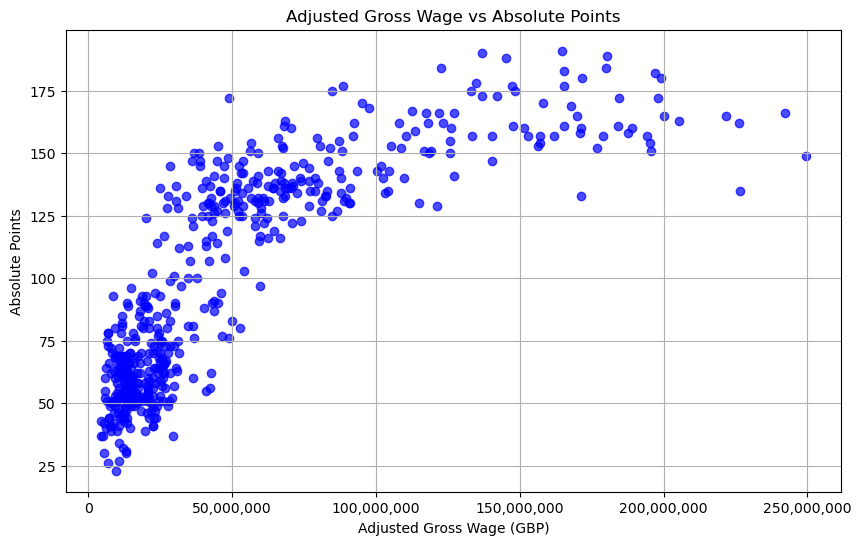

In [35]:
plt.figure(figsize=(10,6))
plt.scatter(df["Adj_Gross_GBP"], df["pts_absolute"], color="blue", alpha=0.7)

# Format x-axis to show full numbers
formatter = FuncFormatter(lambda x, pos: f"{int(x):,}")  # adds commas
plt.gca().xaxis.set_major_formatter(formatter)

plt.title("Adjusted Gross Wage vs Absolute Points")
plt.xlabel("Adjusted Gross Wage (GBP)")
plt.ylabel("Absolute Points")
plt.grid(True)
plt.show()

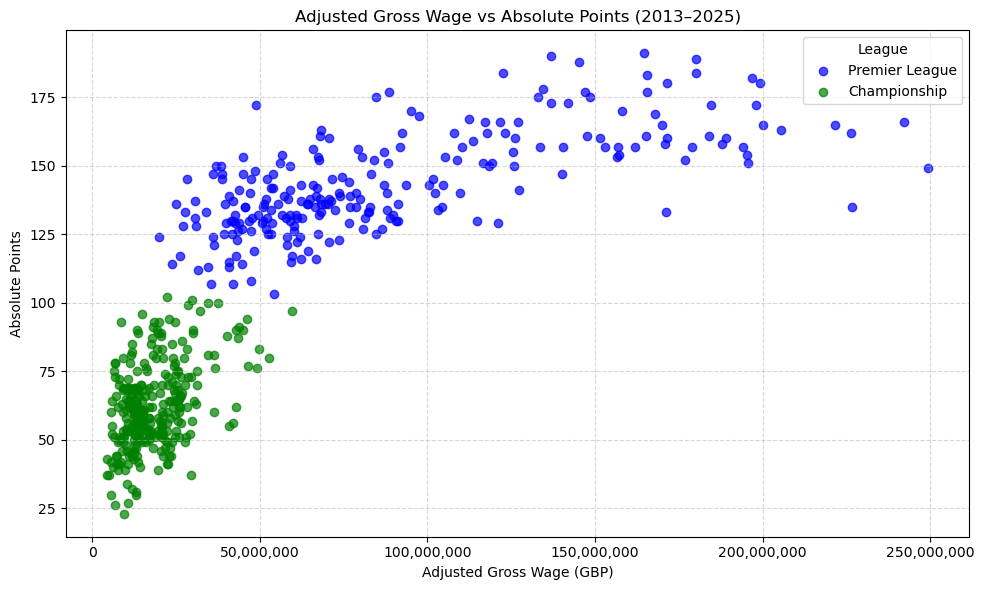

In [36]:
# Define colors for each league
colors = {"Premier League": "blue", "Championship": "green"}

plt.figure(figsize=(10,6))

# Scatterplot using the league column for colors
for league in df["league"].unique():
    subset = df[df["league"] == league]
    plt.scatter(
        subset["Adj_Gross_GBP"],
        subset["pts_absolute"],
        color=colors[league],
        alpha=0.7,
        label=league
    )

# Format x-axis with commas
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

plt.title("Adjusted Gross Wage vs Absolute Points (2013–2025)")
plt.xlabel("Adjusted Gross Wage (GBP)")
plt.ylabel("Absolute Points")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="League")
plt.tight_layout()
plt.show()

In [37]:
# Z-score normalization
df["Adj_Gross_GBP_z"] = zscore(df["Adj_Gross_GBP"])
df["pts_absolute_z"] = zscore(df["pts_absolute"])
df["pyramid_position_z"] = zscore(df["pyramid_position"])

# Compute correlation on normalized values
correlation_norm = df["Adj_Gross_GBP_z"].corr(df["pts_absolute_z"])
correlation_norm_2 = df["Adj_Gross_GBP_z"].corr(df["pyramid_position_z"])
print("Correlation after normalization (points):", correlation_norm)
print("Correlation after normalization (pyramid position):", correlation_norm_2)

Correlation after normalization (points): 0.8053772349873943
Correlation after normalization (pyramid position): -0.7798244615468117


In [38]:
df.head()

,position,team,gp,pts,season,league,league_level,pts_per_game,Gross_PY_GBP,Adj_Gross_GBP,pyramid_position,pts_absolute,Adj_Gross_GBP_z,pts_absolute_z,pyramid_position_z
0,1,Manchester City,38,86,2013-2014,Premier League,1,2.263158,113952000.0,147132001.0,1,177,1.940361,1.775903,-1.693123
1,2,Liverpool,38,84,2013-2014,Premier League,1,2.210526,65562600.0,84652806.0,2,175,0.682462,1.730150,-1.614373
2,3,Chelsea,38,82,2013-2014,Premier League,1,2.157895,105912000.0,136750953.0,3,173,1.731358,1.684396,-1.535624
3,4,Arsenal,38,79,2013-2014,Premier League,1,2.078947,73670800.0,95121913.0,4,170,0.893237,1.615765,-1.456874
4,5,Everton,38,72,2013-2014,Premier League,1,1.894737,52856800.0,68247394.0,5,163,0.352170,1.455627,-1.378124


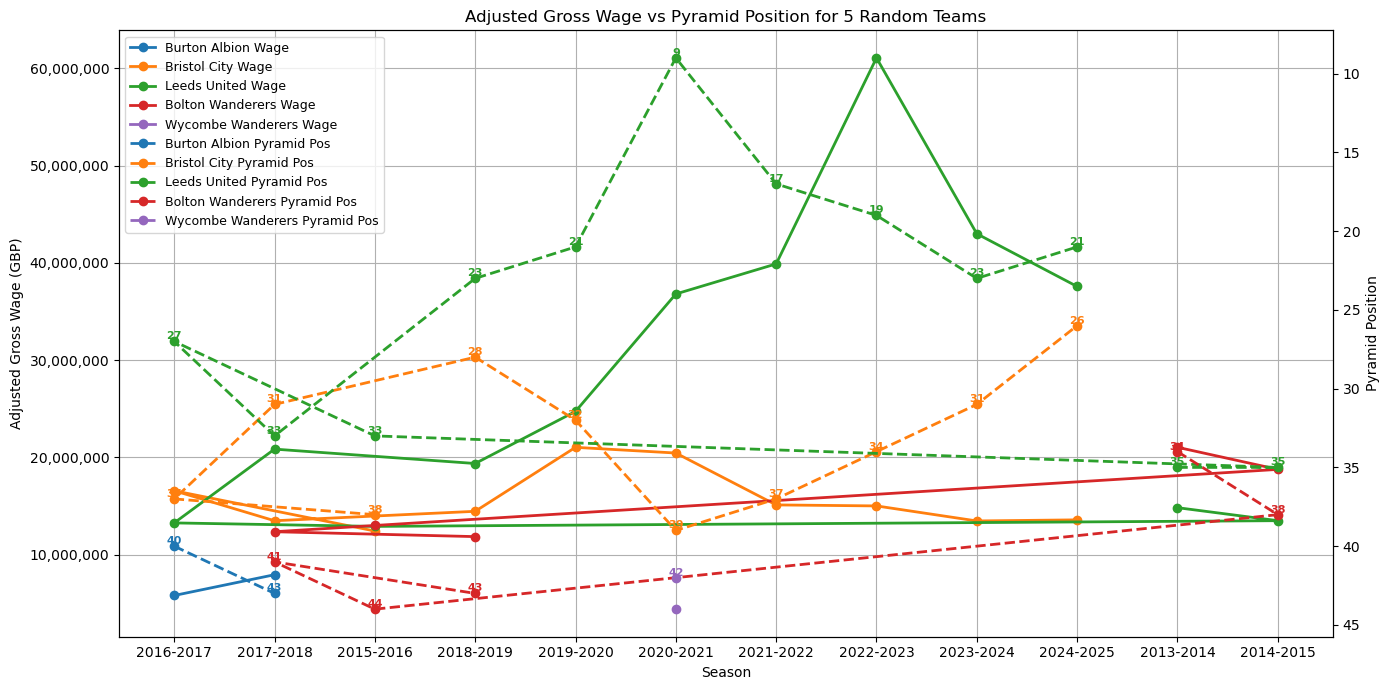

In [39]:
# Randomly pick 5 teams
teams_sample = np.random.choice(df["team"].unique(), 5, replace=False)
colors = plt.cm.tab10.colors  # 10 distinct colors

fig, ax1 = plt.subplots(figsize=(14,7))

for i, team in enumerate(teams_sample):
    team_df = df[df["team"] == team].sort_values("season")
    color = colors[i % 10]
    
    # Line for Adjusted Gross Wage
    ax1.plot(team_df["season"], team_df["Adj_Gross_GBP"], marker="o",
             color=color, linewidth=2, label=f"{team} Wage")
    
    # Secondary y-axis for pyramid position
    ax2 = ax1.twinx() if i == 0 else ax2  # share the same y-axis for pyramid positions
    ax2.plot(team_df["season"], team_df["pyramid_position"], marker="o", color=color,
             linestyle="--", linewidth=2, label=f"{team} Pyramid Pos")
    
    # Annotate pyramid positions on each point
    for _, row in team_df.iterrows():
        ax2.text(row["season"], row["pyramid_position"], str(int(row["pyramid_position"])),
                 ha="center", va="bottom", fontsize=8, fontweight="bold", color=color)

# Axes labels
ax1.set_xlabel("Season")
ax1.set_ylabel("Adjusted Gross Wage (GBP)")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

ax2.set_ylabel("Pyramid Position")
ax2.invert_yaxis()  # 1st place (top of pyramid) at top

# Title
plt.title("Adjusted Gross Wage vs Pyramid Position for 5 Random Teams")
ax1.grid(True)

# Handle legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=9)

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## 8. Regression analysis

### 8.1 Linear regression

##### A simple linear regression relates adjusted wage expenditure to performance.

In [40]:
X = df[["Adj_Gross_GBP"]]  # predictor
y = df["pyramid_position"]  # target

linear_reg = LinearRegression()
linear_reg.fit(X, y)

print("Intercept:", linear_reg.intercept_)
print("Coefficient:", linear_reg.coef_[0])
print("R^2:", linear_reg.score(X, y))


Intercept: 32.61902130601857
Coefficient: -1.9936878259426513e-07
R^2: 0.6081261908267752


### 8.2 Polynomial regression

##### Polynomial specifications allow for non-linear effects of spending.

In [41]:
# Choose degree: 2 for quadratic, 3 for cubic, etc.
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

print("Coefficients:", poly_reg.coef_)
print("Intercept:", poly_reg.intercept_)
print("R^2:", poly_reg.score(X_poly, y))

Coefficients: [ 0.00000000e+00 -4.88825381e-07  1.58661426e-15]
Intercept: 39.30893215673016
R^2: 0.7489124887111485


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


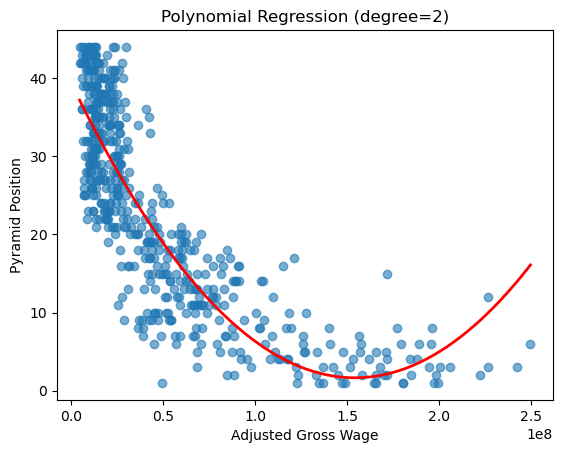

In [42]:
X_plot = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = poly_reg.predict(X_plot_poly)

plt.scatter(X, y, alpha=0.6)
plt.plot(X_plot, y_plot, color='red', linewidth=2)
plt.xlabel("Adjusted Gross Wage")
plt.ylabel("Pyramid Position")
plt.title(f"Polynomial Regression (degree={degree})")
plt.show()

### 8.3 Log-linear and log-quadratic models

##### Log-transforming wages captures diminishing returns to spending at the top end of the distribution.

In [43]:
# X = log of wages
X = np.log(df["Adj_Gross_GBP"].values).reshape(-1, 1)
y = df["pts_absolute"].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predict fitted values
y_pred = model.predict(X)

# Extract coefficients
intercept = model.intercept_
slope = model.coef_[0]

print("Intercept:", intercept)
print("Coef for log(wage):", slope)

# R-squared
r2 = r2_score(y, y_pred)
print("R-squared:", r2)

Intercept: -618.218602574142
Coef for log(wage): 41.45052082543152
R-squared: 0.7856832803547851


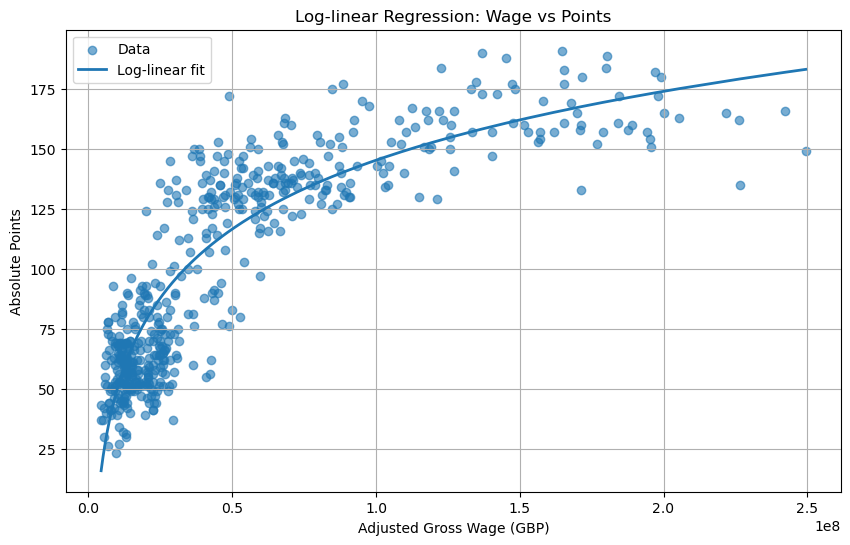

In [44]:
# Sort by wage for smooth line
sorted_idx = np.argsort(df["Adj_Gross_GBP"].values)

wage_sorted = df["Adj_Gross_GBP"].values[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]

plt.figure(figsize=(10,6))
plt.scatter(
    df["Adj_Gross_GBP"],
    df["pts_absolute"],
    alpha=0.6,
    label="Data"
)
plt.plot(
    wage_sorted,
    y_pred_sorted,
    linewidth=2,
    label="Log-linear fit"
)

plt.xlabel("Adjusted Gross Wage (GBP)")
plt.ylabel("Absolute Points")
plt.title("Log-linear Regression: Wage vs Points")
plt.legend()
plt.grid(True)
plt.show()

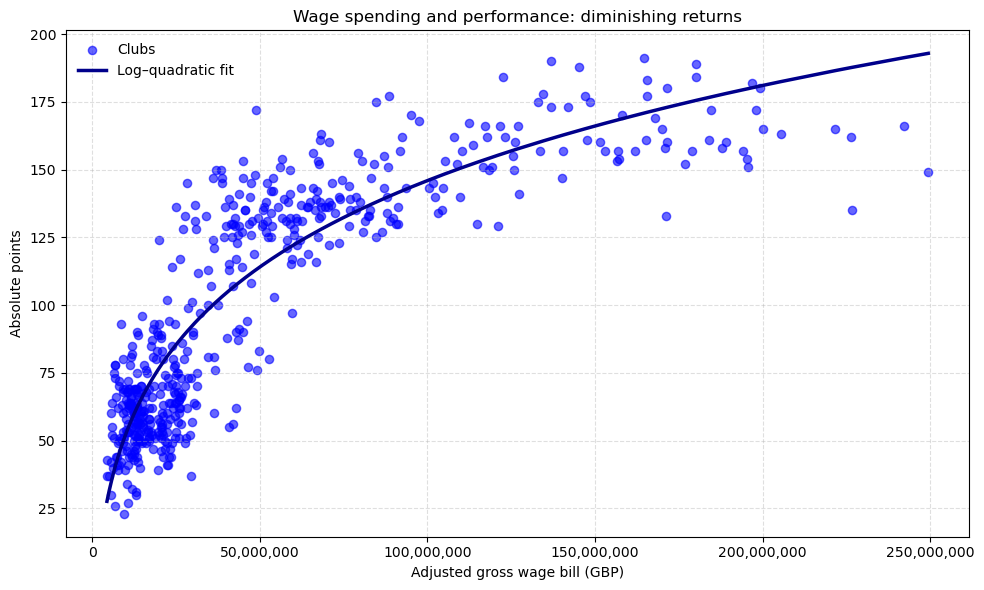

In [47]:
# Log of wages
X_log = np.log(df["Adj_Gross_GBP"].values).reshape(-1, 1)
y = df["pts_absolute"].values

# Polynomial regression (degree 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_log, y)
y_poly_pred = poly_model.predict(X_log)

# Sort for smooth line plotting
sorted_idx = np.argsort(df["Adj_Gross_GBP"].values)
X_sorted = df["Adj_Gross_GBP"].values[sorted_idx]
y_poly_sorted = y_poly_pred[sorted_idx]

plt.figure(figsize=(10,6))

# Scatter points (blue)
plt.scatter(
    df["Adj_Gross_GBP"],
    df["pts_absolute"],
    color="blue",
    alpha=0.6,
    s=35,
    label="Clubs",
)

# Fitted curve (green)
plt.plot(
    X_sorted,
    y_poly_sorted,
    color="darkblue",
    linewidth=2.5,
    label="Log–quadratic fit",
)

# Axis formatting
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.xlabel("Adjusted gross wage bill (GBP)")
plt.ylabel("Absolute points")
plt.title("Wage spending and performance: diminishing returns")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [48]:
# Extract coefficients
linreg = poly_model.named_steps['linearregression']
coef = linreg.coef_
intercept = linreg.intercept_

print("Intercept:", intercept)
print("Coef for log(wage):", coef[1])
print("Coef for log(wage)^2:", coef[2])

# Compute R-squared
r2 = r2_score(y, y_poly_pred)
print("R-squared:", r2)

Intercept: 390.16435766467237
Coef for log(wage): -74.8333734089387
Coef for log(wage)^2: 3.342626837096887
R-squared: 0.7904414120606622


Wages are strongly associated with performance, explaining nearly 80% of the cross-team variation in points, though this should not be interpreted as a causal effect.

### 8.4 Log-linear and log-quadratic models for Pyramid Position

In [49]:
# X = log of wages
X = np.log(df["Adj_Gross_GBP"].values).reshape(-1, 1)
y = df["pyramid_position"].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predict fitted values
y_pred = model.predict(X)

# Extract coefficients
intercept = model.intercept_
slope = model.coef_[0]

print("Intercept:", intercept)
print("Coef for log(wage):", slope)

# R-squared
r2 = r2_score(y, y_pred)
print("R-squared:", r2)

Intercept: 225.0499702133986
Coef for log(wage): -11.700001291246545
R-squared: 0.7417654649119907


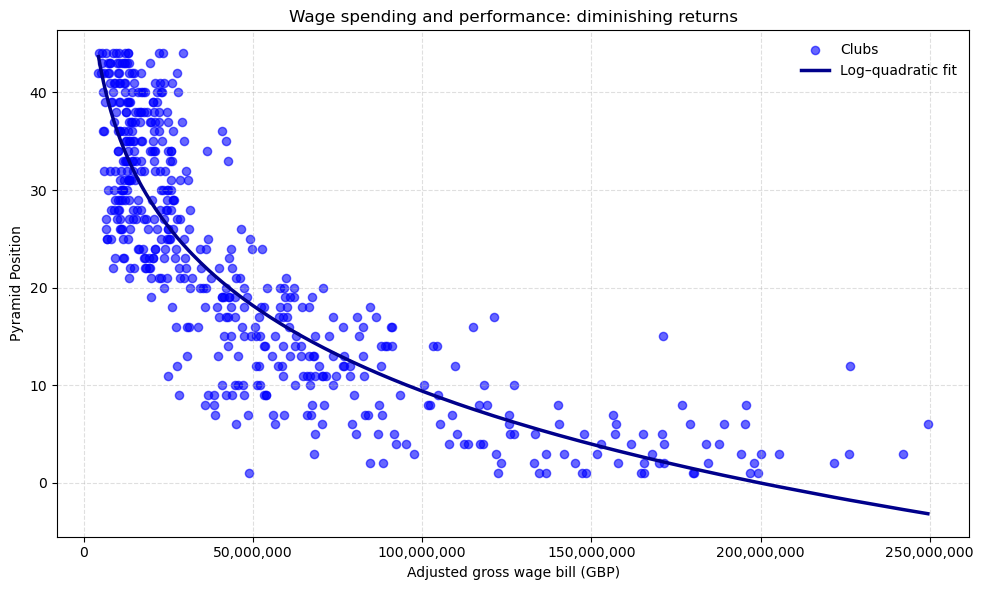

In [50]:
# Pyramid Position

# Log of wages
X_log = np.log(df["Adj_Gross_GBP"].values).reshape(-1, 1)
y = df["pyramid_position"].values

# Polynomial regression (degree 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_log, y)
y_poly_pred = poly_model.predict(X_log)

# Sort for smooth line plotting
sorted_idx = np.argsort(df["Adj_Gross_GBP"].values)
X_sorted = df["Adj_Gross_GBP"].values[sorted_idx]
y_poly_sorted = y_poly_pred[sorted_idx]

plt.figure(figsize=(10,6))

# Scatter points (blue)
plt.scatter(
    df["Adj_Gross_GBP"],
    df["pyramid_position"],
    color="blue",
    alpha=0.6,
    s=35,
    label="Clubs",
)

# Fitted curve (green)
plt.plot(
    X_sorted,
    y_poly_sorted,
    color="darkblue",
    linewidth=2.5,
    label="Log–quadratic fit",
)

# Axis formatting
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.xlabel("Adjusted gross wage bill (GBP)")
plt.ylabel("Pyramid Position")
plt.title("Wage spending and performance: diminishing returns")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [51]:
# Extract coefficients
linreg = poly_model.named_steps['linearregression']
coef = linreg.coef_
intercept = linreg.intercept_

print("Intercept:", intercept)
print("Coef for log(wage):", coef[1])
print("Coef for log(wage)^2:", coef[2])

# Compute R-squared
r2 = r2_score(y, y_poly_pred)
print("R-squared:", r2)

Intercept: 17.295872386750602
Coef for log(wage): 12.257618473281644
Coef for log(wage)^2: -0.6886713186305098
R-squared: 0.7441587361562163


## 9. Interpretation

##### Wages are strongly associated with performance, explaining nearly **80% of the cross-team variation in points**.

##### This result is consistent with findings in [*Soccernomics*](https://www.amazon.co.uk/Soccernomics-Simon-Kuper/dp/0007586523/ref=sr_1_5) (Kuper & Szymanski), which argue that:
##### - Football labour markets are reasonably efficient
##### - Wages proxy talent
##### - Talent is the dominant determinant of outcomes

##### ⚠️ These results should not be interpreted as causal.